In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import spacy
from nltk.corpus import stopwords
import re
from collections import Counter
import networkx as nx

In [2]:
df = pd.read_csv('data/criterion_cleaned.csv')

in this notebook I'll be plotting a variety of initially very basic graphs. It will eventually become more sophisticated but for now I'm just aiming to get to know the data as fast as possible really.


**bar charts**

here, I just want the most basic shape info on some of these variables, starting with some count plots
hopefully this will start to form a picture of what the data actually is

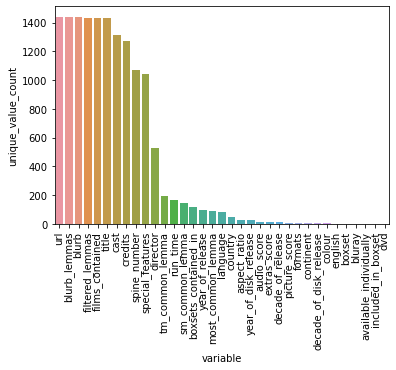

In [4]:
### unique value counts visualised ###

unique_vals = df.nunique().reset_index().sort_values(by=0, ascending=False)
unique_vals.columns = ['variable', 'unique_value_count']

sns.barplot(x='variable',
            y='unique_value_count',
            data=unique_vals)
plt.xticks(rotation=90)
plt.show()

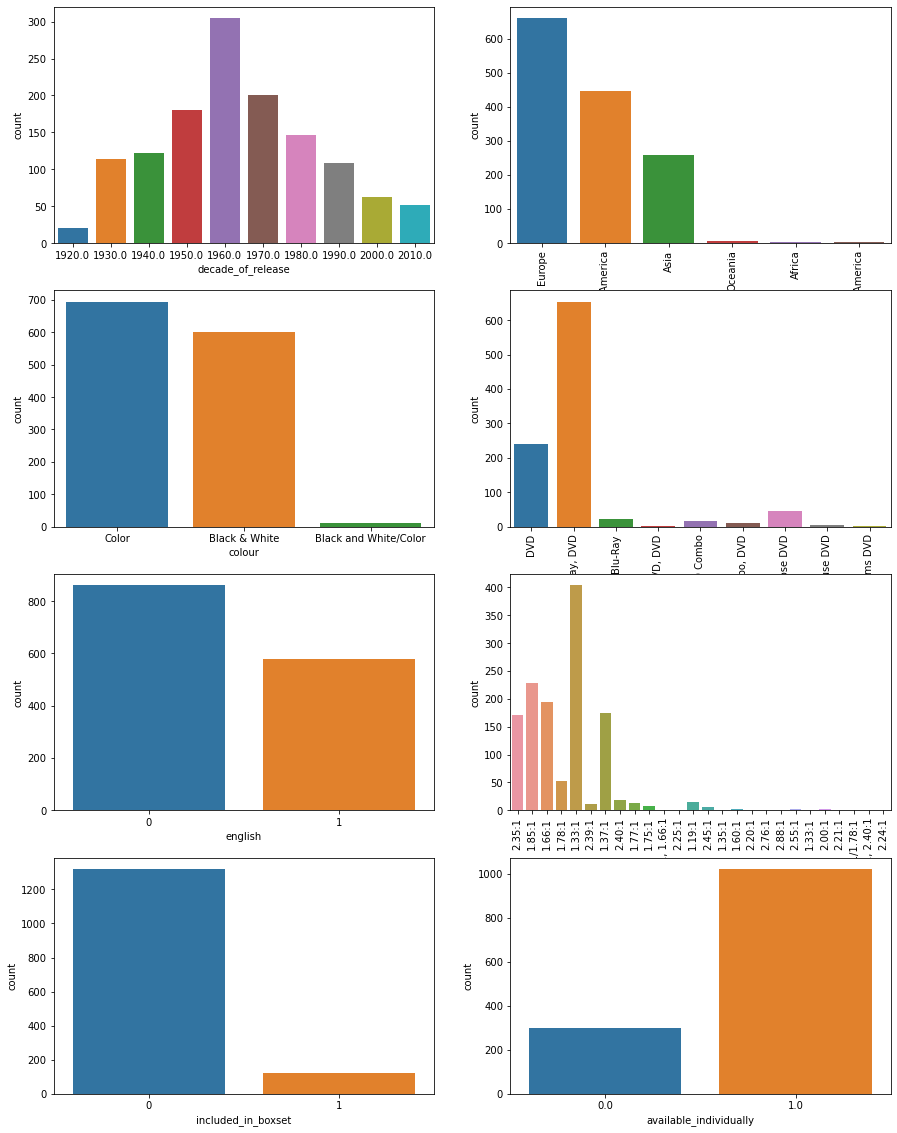

In [4]:
### value count plots for some arbitrary vars ###

count_plot_cols = [('decade_of_release', [0, 0]), 
                   ('continent', [0, 1]),
                   ('colour', [1, 0]),
                   ('formats', [1, 1]),
                   ('english', [2, 0]),
                   ('aspect_ratio', [2, 1]),
                   ('included_in_boxset', [3, 0]),
                   ('available_individually', [3, 1])]

fig, ax = plt.subplots(4, 2, figsize=(15, 20))

for col_tuple in count_plot_cols:
    sns.countplot(x=col_tuple[0], data=df,
                  ax=ax[col_tuple[1][0], col_tuple[1][1]])

for i in range(0, 3):
    plt.setp(ax[i, 1].xaxis.get_majorticklabels(), rotation=90)

plt.show()

a few initial insites:
- nice normal curve on decade of release
- wasnt expecting anything to be both black and white and colour really, wonder what films they are?
- interestingly very few films are solely on blu ray
- would be nice if I could read the axis hahaha
- there are a large number of aspect ratios that are basically unused
- 300 movies arent available individually. this is fewer than were included in boxsets...? something isnt adding up here there must be more movies with a null valued spine number who arent boxsets than i realised?
- of the movies with language data available, there are more without enlish than with

**Line Graphs**

this section will ocntain some basic line graph plots

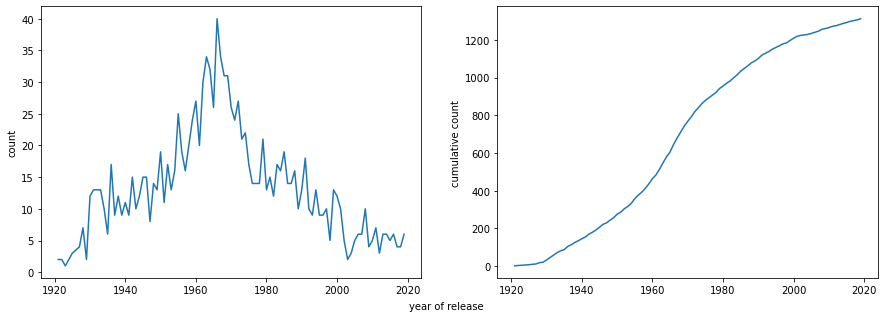

In [49]:
### basic line graphs for counts of releases per year ###

year_of_release_counts = pd.DataFrame(df.groupby('year_of_release').count()['country'])
year_of_release_counts.reset_index(inplace=True)
year_of_release_counts.columns = ['year_of_release', 'count']
year_of_release_counts['cumulative_count'] = year_of_release_counts['count'].cumsum()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot('year_of_release', 'count', data=year_of_release_counts)
ax[0].set_ylabel('count')

ax[1].plot('year_of_release', 'cumulative_count', data=year_of_release_counts)
ax[1].set_ylabel('cumulative count')

fig.text(0.5, 0.04, 'year of release', ha='center')

plt.show()

these are basic count plots for number of films released over time, again showing the general trend toward 1960's that we saw in the bar chat before. in all honesty not much has been gained from this but ack well guess its here now. wouldnt mind prehaps producing plot one again, but this time with separate lines for each value of certain variables (continent and colour jump out to me as semi interesting)

something that I have noted as a bit weird is that the count of films per year is very low for 1990 - present. I'm a normie bitch so most of my favourite films and directors in the collection are from that period, alot of whom have multiple films in covered by the collection. I'd guess from this that with more modern releases they tend to release alot from individual directors rather than as much diversity prehaps? 

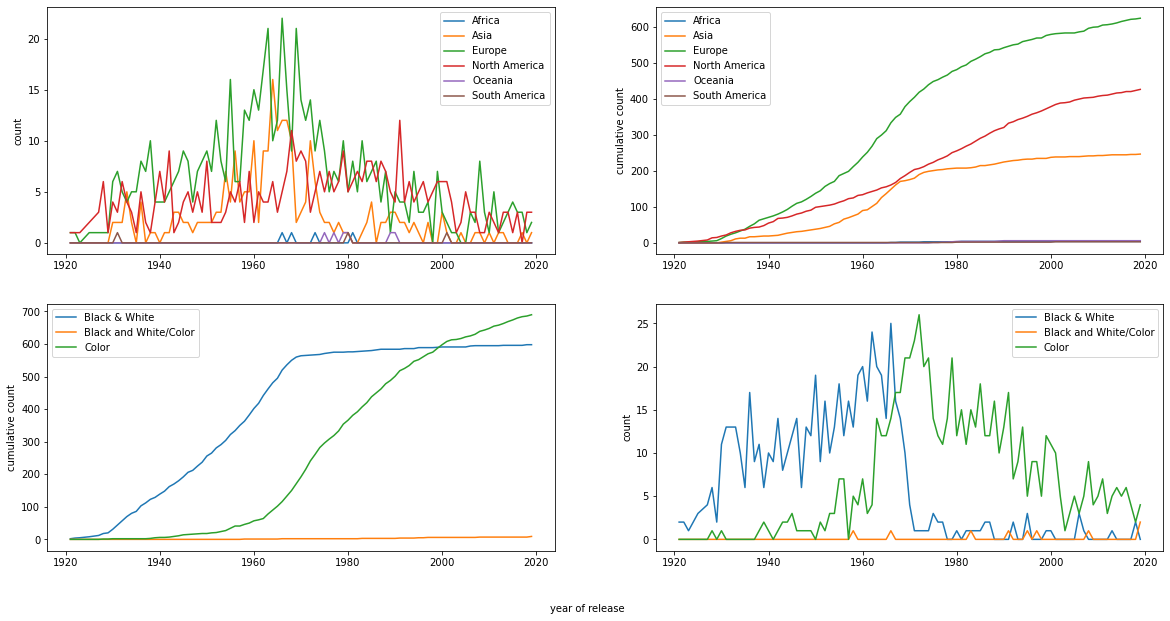

In [107]:
### multiline time series for certain columns ###

year_continent_counts = pd.pivot_table(df, values='title', index='year_of_release', columns='continent', 
                                      aggfunc=pd.Series.nunique, fill_value=0)
year_continent_cum_counts = year_continent_counts.cumsum()

year_colour_counts = pd.pivot_table(df, values='title', index='year_of_release', columns='colour', 
                                      aggfunc=pd.Series.nunique, fill_value=0)
year_colour_cum_counts = year_colour_counts.cumsum()

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

lines = ax[0, 0].plot(year_continent_counts)
ax[0, 0].set_ylabel('count')
ax[0, 0].legend(lines, sorted(df.continent.dropna().unique()))

lines = ax[0, 1].plot(year_continent_cum_counts)
ax[0, 1].set_ylabel('cumulative count')
ax[0, 1].legend(lines, sorted(df.continent.dropna().unique()))

lines = ax[1, 1].plot(year_colour_counts)
ax[1, 1].set_ylabel('count')
ax[1, 1].legend(lines, sorted(df.colour.dropna().unique()))

lines = ax[1, 0].plot(year_colour_cum_counts)
ax[1, 0].set_ylabel('cumulative count')
ax[1, 0].legend(lines, sorted(df.colour.dropna().unique()))

fig.text(0.5, 0.04, 'year of release', ha='center')

plt.show()

I'm not convinced by this one - the value counts graph for continent had correct numbers which dont appear to line up with the cumulative sum graph, in particular for Asia and North America. colour looks about right though. 

that aside the code is quite ugly, surely they can be to some extent automated?

- black and white just drops off around the 70's which is kind of interesting i guess.
- its no longer here but i originally tried plotting the cumulative graphs based on unique spine number count and found asia had way less movies than it does with title, i guess this suggests some large proportion of asian films in the collection are only available via boxset?

**Release Country Chloropleth plot**

Next I want to do some spatial analysis just because its been a while and I fancy it. first, lets go with number of unique titles released per country.

In [160]:
countries_polygons = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries_polygons.drop(['pop_est', 'gdp_md_est'], axis=1, inplace=True)

movies_by_country = df[['title', 'country']].groupby('country').count().reset_index()
countries_poly = countries_polygons.name.unique().tolist()
countries_data = movies_by_country.country.unique().tolist()

missing_polys = [country for country in countries_data if country not in countries_poly]
print(len(missing_polys))
print(missing_polys[:10])

6
['Czechoslovakia', 'Hong Kong', 'Soviet Union', 'United States', 'West Germany', 'Yugoslavia']


so a few of the desolved countries, the USSR, the USA and Hong Kong are all missing polygons. I'll have to replace them in movies_by_country with their closest equivalents who have a polygon available.

In [161]:
movies_by_country.loc[movies_by_country.country == 'Czechoslovakia', 'country'] = 'Czechia'
movies_by_country.loc[movies_by_country.country == 'West Germany', 'country'] = 'Germany'
movies_by_country.loc[movies_by_country.country == 'Yugoslavia', 'country'] = 'Serbia'
movies_by_country.loc[movies_by_country.country == 'Hong Kong', 'country'] = 'China'
movies_by_country.loc[movies_by_country.country == 'United States', 'country'] = 'United States of America'
movies_by_country.loc[movies_by_country.country == 'Soviet Union', 'country'] = 'Russia'

There are some political hotakes in that code, but its just what needs to be done to get the data we have to match that of the available polygons. we can now join the data on to the gpdf and make a chloropleth plot.

nice to see these polygons would've given us the continents anyways without all that damn fiddling hahaha.

for now, We'll be binning the value of criterion_count. this is simply done because otherwise US will completely dominante the map and leave everything else blank (it has over 400 unique titles attached!)

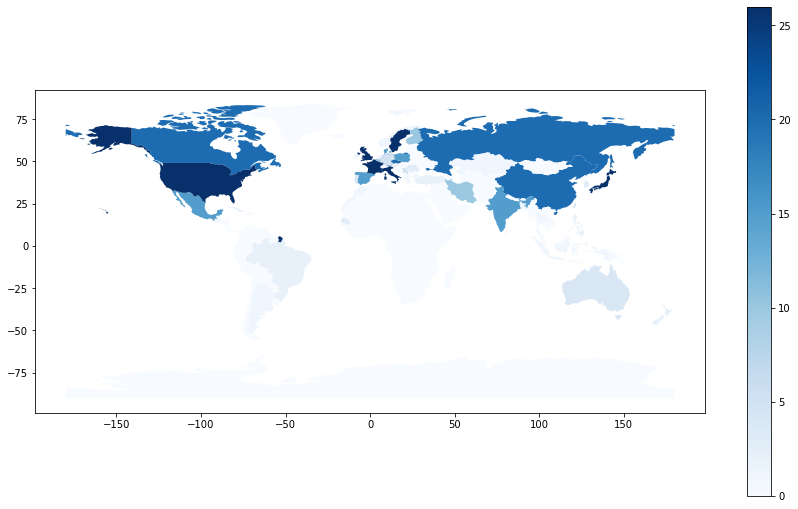

In [162]:
movies_by_country.columns = ['name', 'criterion_release_count']
movies_by_country = pd.merge(movies_by_country, countries_polygons, 
                             on='name', how='outer')
movies_by_country.criterion_release_count.fillna(0, inplace=True)
movies_by_country = gpd.GeoDataFrame(movies_by_country)

bins = [0, 0.5, 1, 2, 3, 4, 5, 10, 15, 20, 25, float('inf')]
labels = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 26]
movies_by_country['criterion_release_count_binned'] = pd.cut(movies_by_country['criterion_release_count'], 
                                  bins=bins, labels=labels)

movies_by_country.criterion_release_count_binned.fillna(0, inplace=True)

ax = movies_by_country.plot(column='criterion_release_count_binned', 
                            cmap = 'Blues', figsize=(15, 9),   
                            legend=True)

other than emphasising that Asias continent dominance is driven seemingy mostly by Japan this doesnt honestly tell us all that much we didn't already know. It is interesting however to see the loss of almost all of the african continent, along with large parts of South America I guess. I also don't think I was expecting Sweeden to show up as darkly as it does here.

Other than directors by country I'm not too sure how much use further spatial analysis might serve in all honesty...


**Natural Language Stuff**

I've not done much NLP before but i think the free text descriptions is a good oportunity to try some stuff out. It will probably be embaressingly rudimentary but ack well all about the learning process isnt it.

For my first trick I will reduce the blurb to a list of lemmatised tokens. Tadah!:

In [45]:
def remove_words_from_string(
    text,
    stop_words,
):
    """Remove each of a list of stop words from a larger text.
    
    Parameters
    ----------
    text : string
        The text to be purged of the stop words.
    stop_words : list
        List of words to be purged from the text.
    
    Returns
    -------
    string
        Text, but with stop words removed
    """
    for word in stop_words:
        text = text.replace(' ' + str(word) + ' ', ' ')
    
    return text


def lemmatise_document(
    director_name,
    films_contained,
    blurb,
    stop_words,
):
    """Function to take film blurb, remove all references to director and movie title, 
    remove stop words and then lemmatise.
    
    Parameters
    ----------
    director_name : string
        Name of films director, or np.NaN if not available.
    films_contained : list
        List of strings describing the films contained in a boxset, or just the name of 
        the film if not a boxset.
    blurb : string
        text description of the movie / the release. This will be lemmatised.
    stop_words : list
        List of stop words to be removed from the lemmatised list.
        
    Returns
    -------
    string
        comma separated list of lemmatised tokens.
    """
    stop_words.append(director_name)
    stop_words += films_contained.split(',')
    
    blurb = remove_words_from_string(blurb, stop_words[::-1])
    blurb = re.sub(r'[0-9]+', '', re.sub(r'[^\w]', ' ', blurb))  # remove numbers / punctuation
    
    tokens = sp(blurb)
    lemmatised_blurb = [str(word.lemma_) for word in tokens]
    lemmatised_blurb = [
        word for word in lemmatised_blurb
        if word not in ['  ', ' ', '-PRON-', 's']
    ]
    lemmatised_blurb = ', '.join(lemmatised_blurb)
    
    return lemmatised_blurb
    
    
sp = spacy.load('C:/Users/johnc/Anaconda3/Lib/site-packages/en_core_web_sm/en_core_web_sm-2.3.1')
# cannot get it to import with just the file name so used the full path... :(

stop_words = stopwords.words('english')

df['blurb_lemmas'] = df.apply(
    lambda x: lemmatise_document(x['director'], x['films_contained'], x['blurb'], stop_words), axis=1
)

In [54]:
df[['blurb', 'blurb_lemmas']][:5]

,blurb,blurb_lemmas
0,In 2 or 3 Things I Know About Her (2 ou 3 chos...,"in, ou, chose, que, je, sais, d, elle, beckon,..."
1,"In this beautifully shot, psychologically comp...","in, beautifully, shoot, psychologically, compl..."
2,Few directors have portrayed the agonies and e...,"few, director, portray, agony, epiphanie, grow..."
3,"In the late 1940s, the incandescent Hollywood ...","in, late, incandescent, Hollywood, star, Ingri..."
4,"Vienna-born, New York-raised Josef von Sternbe...","Vienna, bear, New, York, raise, direct, influe..."


I've opted to lemmatise since i might need the text in future and it'll be easier if its in legible English. That said I'm somewhat supprised that lemmatisation isnt able to correctly identify things like 'New York' as being a single noun.

Though initially I'd hoped to do some TF/IDF work here looking at the values we get out of some arbitrary examples gives me second thoughts on the usefullness of that - it seems like they've gone out of their way to avoid using the same word more than twice at all costs hahaha. Prehaps if we get a set of popular words across the entire document first we can do something meaningful here?

I guess developing some kind of dictionary of important meaningful words for film in general might go some way toward helping to classify with the lemmas...?

It migth be cool to also get a feel for how the films are linked using words - maybe some kind of graph can be built?

I dunno, to carry on with the work though lets start by getting an idea of the popularity of the various lemmas...:

In [84]:
all_lemmas = df.blurb_lemmas.tolist()
all_lemmas = ', '.join(all_lemmas).split(',')
all_lemmas = [lemma.strip().lower() for lemma in all_lemmas
             if lemma not in stop_words]

lemma_counts = {}

for lemma in list(set(all_lemmas)):
    lemma_counts[lemma] = all_lemmas.count(lemma)

lemma_counts = pd.DataFrame(lemma_counts.items())
lemma_counts.columns = ['lemma', 'count']

lemma_counts.describe()

,count
count,14597.000000
mean,6.270604
std,22.267223
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,1179.000000


ok so lots to go on here, to break it down:
 - 14.5k unique lemmas is initially daunting
 - nearly 12k of these are present in 4 or fewer descriptions so thats less of a concern
 - the most popular lemma is present in like just <10% of all films, I'd guess at it being something silly like the word 'film'

In [85]:
lemma_counts.sort_values(by='count', ascending=False, inplace=True)
lemma_counts.head(5)

,lemma,count
8166,film,1179
1283,the,799
12826,one,653
11985,director,491
2573,a,482


...yeah... tits... never more frustrated to be dead on the money hahaha
<br>OK so why is 'the' still here when surely its a stop word? and surely 'a' is too... other than this I'd actually say most of these more popular ones are unhelpful so to speak hahaha. Plan of attack then:
 - remove the most common and therefore useless words in the lemma list
 - see whats left
 - if it still looks shit consider building / finding a 'film words' dictionary and seeing what power that has...?

<AxesSubplot:xlabel='order of popularity', ylabel='number of uses in corpus'>

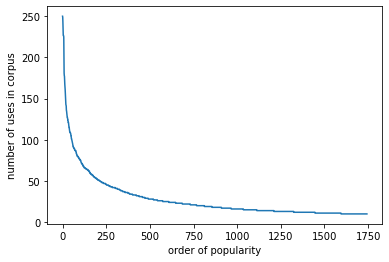

In [86]:
most_common_words = tuple(open('data/most_common_words.txt', 'r'))  # random list I found online, seems legit though
most_common_words = [word.replace('\n', '') for word in most_common_words]

lemma_counts = lemma_counts[~lemma_counts['lemma'].isin(most_common_words)]
lemma_counts = lemma_counts[lemma_counts['count'].between(10, 250)]  

lemma_counts.reset_index().plot.line(y='count',
                                     xlabel='order of popularity',
                                     ylabel='number of uses in corpus',
                                     legend=False)

At this point I moved the data to excel and manually created a binary column for it, where I used a value of 1 to mark words I thought were relevant to the project and left the rest as 0. I hoped this would allow me to create a meaningful dictionary of 'film relevant' words to further this investigation with rather than getting bogged down with words that just hold no real meaning in context.

I have also added an extra column title 'category' where I have attemoted to group similarly themed words into a common title for all the cases where include_word is equal to 1. Since its me this is unlikely to be 100% accurate but its better than nothing at all.

In [3]:
lemma_counts = pd.read_excel('data/lemma_counts.xlsx')

lemma_counts = lemma_counts[lemma_counts['include_word']==1]

filtered_lemmas = lemma_counts.lemma.tolist()

print(lemma_counts.shape)
lemma_counts.head(10)

(472, 4)


,lemma,count,include_word,category
0,war,178,1,war
1,family,177,1,family
2,portrait,150,1,character study
3,comedy,143,1,comedy
4,drama,141,1,drama
6,french,128,1,international
7,classic,121,1,classic
8,hollywood,119,1,classic
9,shoot,115,1,action
10,century,113,1,period


so I'm not convinced I was fully accurate with the labelling but at least its something hahaha. I think prehaps a 'most popular lemma' column and a 'Johns poxy selected lemmas' column might be worth investigating...

In [4]:
def find_filtered_lemmas(
    lemma_list,
    filtered_lemmas_list
):
    """Find which lemmas from one string are in a list.
    
    Parameters
    ----------
    lemma_list : string
        Deceptively named no?
    filltered_lemma_list : list
        List of lemmas to look for.
        
    Returns
    -------
    string
        Comma separated string of filtered lemmas that are in lemma list.
    """
    lemma_list = lemma_list.split(',')
    lemma_list = [lemma.strip().lower() for lemma in lemma_list]
    
    included_filtered_lemmas = [lemma for lemma in lemma_list 
                               if lemma in filtered_lemmas_list]
    included_filtered_lemmas = ', '.join(included_filtered_lemmas)
    
    return included_filtered_lemmas


def most_popular_lemma(
    included_filtered_lemmas,
    ordered_lemmas,
    ignored_lemmas=[],
):
    """Find the most common of the lemmas included in included_filtered_lemmas.
    
    Parameters
    ----------
    included_filtered_lemmas : string
        Comma separated string of lemmas
    ordered_lemmas : list
        Ordered list of lemmas based on popularity.
    ignored_lemmas : list
        List of lemmas not to return no matter what lad.
        
    Returns
    -------
    string
        The most popular of the included lemmas.
    """
    included_filtered_lemmas = included_filtered_lemmas.replace(' ', '').split(',')
    for lemma in ordered_lemmas:
        if lemma in included_filtered_lemmas and lemma not in ignored_lemmas:
            return lemma


df['filtered_lemmas'] =  df.apply(lambda x: find_filtered_lemmas(x['blurb_lemmas'], filtered_lemmas), axis=1)
df['most_common_lemma'] = df.apply(lambda x: most_popular_lemma(x['filtered_lemmas'], filtered_lemmas), axis=1)
df['sm_common_lemma'] = df.apply(
    lambda x: most_popular_lemma(x['filtered_lemmas'], filtered_lemmas, [x['most_common_lemma']]), axis=1
)
df['tm_common_lemma'] = df.apply(
    lambda x: most_popular_lemma(x['filtered_lemmas'], filtered_lemmas, [x['most_common_lemma'], 
                                                                         x['sm_common_lemma']]), axis=1
)

df[['title', 'blurb_lemmas', 'filtered_lemmas', 'most_common_lemma', 'sm_common_lemma', 'tm_common_lemma']].head(10)

,title,blurb_lemmas,filtered_lemmas,most_common_lemma,sm_common_lemma,tm_common_lemma
0,2 or 3 Things I Know About Her,"in, ou, chose, que, je, sais, d, elle, beckon,...","money, sex, fashion, city, love, war, legendar...",war,french,city
1,3:10 to Yuma,"in, beautifully, shoot, psychologically, compl...","shoot, western, train, prison, simple, mission...",shoot,action,simple
2,3 Films by Louis Malle,"few, director, portray, agony, epiphanie, grow...","autobiographical, heart, war, ii, postwar, fra...",war,ii,heart
3,3 Films by Roberto Rossellini Starring Ingrid ...,"in, late, incandescent, Hollywood, star, Ingri...","hollywood, revolutionary, series, melodrama, w...",portrait,hollywood,series
4,3 Silent Classics by Josef von Sternberg,"Vienna, bear, New, York, raise, direct, influe...","york, influential, drama, hollywood, silent, d...",drama,hollywood,class
5,3 Women,"in, dusty, underpopulated, California, resort,...","california, town, modern, hero, sinister, mast...",masterpiece,town,modern
6,4 by Agnes Varda,"Agnes, Varda, use, skill, hone, early, career,...","french, art, bourgeois, code, poet",french,art,poet
7,"4 Months, 3 Weeks and 2 Days","romanian, filmmaker, shoot, international, pro...","shoot, international, realistic, win, college,...",shoot,win,international
8,8 1/2,"one, great, film, film, ever, make, Federico, ...","personal, consciousness, flashback, dream, rea...",masterpiece,personal,epic
9,12 Angry Men,"Angry, Men, Sidney, Lumet, may, radical, court...","drama, history, iconic, adaptation, white, mur...",drama,adaptation,history


ok so not too bad to be fair, starting to get a feel for these films from the top 3 lemmas. 'masterpiece' and 'live' might've been a mistake to include though hahaha. Its interesting to me how the ones that are most vague are from the boxsets here, which I think is reassuring?

I wonder if there are any films here without any common lemmas? or with trash common lemmas too I guess, but that less so

<AxesSubplot:ylabel='NULL count'>

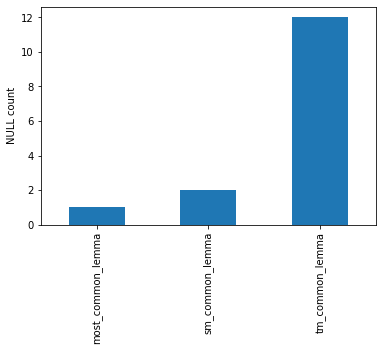

In [5]:
df[['most_common_lemma', 'sm_common_lemma', 'tm_common_lemma']].isnull().sum().plot(kind='bar', ylabel='NULL count')

holy whores have thouroughly fucked my plans! curses! dangit dangit twice!!
<br> thats the only film with no common lemmas at all at least. Minimal without all three is also probs a good thing. 

next I'll do something with that 'category' column, first thought is to added a filtered_category column that will replace all lemmas in 'filtered_lemmas' with their matched category. it might then also be a good idea to find the most common categories of each film (still go with top 3?), and repeat fill the most popular in cases where there aren't three separate ideas.


In [29]:
def replace_lemmas_with_category(
    filtered_lemmas,
    category_df,
):
    """Replace all elements in a list with a mapped value where appropriate. Remove them from the list if not.
    
    Parameters
    ----------
    filtered_lemmas : string
        Comma separated string of lemmas.
    category_df : pd.DataFrame
        Dataframe containing a 'lemma' and 'category' column to act as a map.
        
    Returns
    -------
    string
        Comma separated string of mapped categories.
    """
    filtered_lemmas = filtered_lemmas.replace(' ', '').split(',')
    filtered_lemmas = pd.DataFrame(filtered_lemmas, columns=['lemma'])
    
    filtered_lemmas = pd.merge(filtered_lemmas, category_df, on='lemma', how='left')
    
    lemma_categories = ', '.join(filtered_lemmas.category.dropna().tolist())
    
    return lemma_categories


def most_popular_category(
    categories,
    depth,
):
    """Find the most popular category in a given list.
    
    Parameters
    ----------
    categories : string
        Comma separated list of available categories.
    depth : int
        Which most popular category will you go with, assuming one exists.
        
    Returns
    -------
    string
        The most popular category.
    """
    categories = categories.replace(' ', '').split(',')
    categories = pd.Series(Counter(categories))  # creates a series of value counts
    
    if depth in range(len(categories)):
        return categories.sort_values(ascending=False).index[depth]
    
    elif len(categories) > 0:
        return categories.sort_values(ascending=False).index[0]
    
    else:
        return 'Unknown'
    

df['filtered_lemma_cats'] =  df.apply(lambda x: replace_lemmas_with_category(x['filtered_lemmas'], lemma_counts), axis=1)
df['most_frequent_category'] = df.apply(lambda x: most_popular_category(x['filtered_lemma_cats'], 0), axis=1)
df['sm_frequent_category'] = df.apply(lambda x: most_popular_category(x['filtered_lemma_cats'], 1), axis=1)
df['tm_frequent_category'] = df.apply(lambda x: most_popular_category(x['filtered_lemma_cats'], 2), axis=1)

df[['filtered_lemmas', 'filtered_lemma_cats', 'most_frequent_category', 'sm_frequent_category', 'tm_frequent_category']]

,filtered_lemmas,filtered_lemma_cats,most_frequent_category,sm_frequent_category,tm_frequent_category
0,"money, sex, fashion, city, love, war, legendar...","money, sex, fashion, urban, romantic, war, cla...",international,romantic,sex
1,"shoot, western, train, prison, simple, mission...","action, western, journey, crime, simple, spy, ...",action,political,thriller
2,"autobiographical, heart, war, ii, postwar, fra...","autobiographical, emotional, war, war, war, in...",war,emotional,tragedy
3,"hollywood, revolutionary, series, melodrama, w...","classic, political, series, drama, female, war...",characterstudy,romantic,international
4,"york, influential, drama, hollywood, silent, d...","urban, classic, drama, classic, silent, crime,...",crime,political,classic
...,...,...,...,...,...
1436,"french, international, art, independent, perso...","international, international, arthouse, indepe...",characterstudy,political,spiritual
1437,"czech, action, postwar, legend, fantasy, adven...","international, action, war, classic, fantasy, ...",adventure,international,period
1438,"giant, italian, poetry, neorealism, dream, mem...","monster, international, arthouse, arthouse, ar...",arthouse,fantasy,horror
1439,"culture, martial, art, hong, kong, hollywood, ...","political, fighting, arthouse, international, ...",international,arthouse,action



I'm going to get a bit experimental here, and plot a graph network connecting the first, second and third most common lemmas.

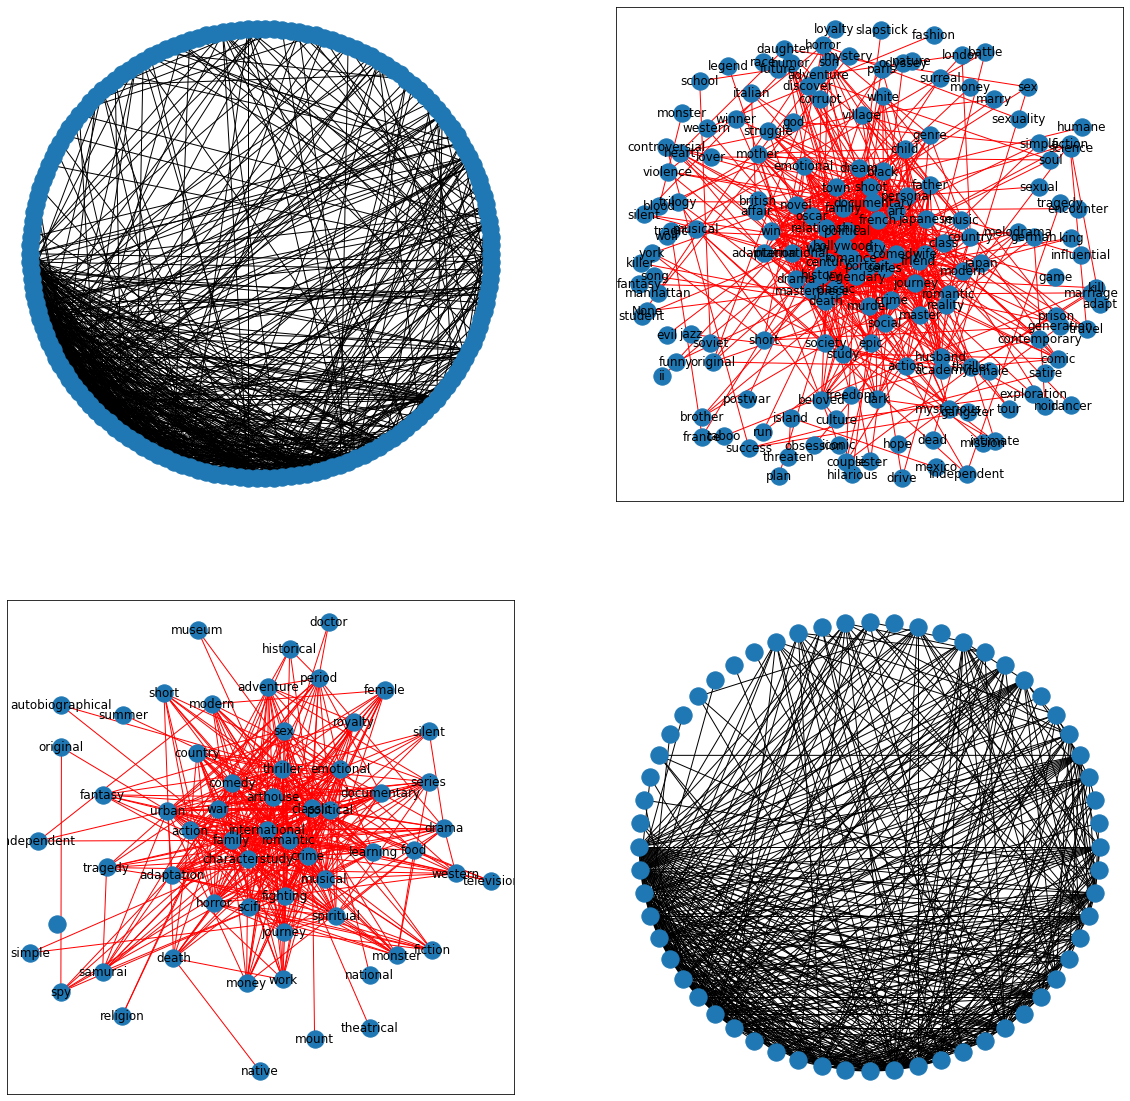

In [39]:
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(df, 'most_common_lemma', 'sm_common_lemma', 'tm_common_lemma')

G2 = nx.Graph()
G2 = nx.from_pandas_edgelist(df, 'most_frequent_category', 'sm_frequent_category', 'tm_frequent_category')

fig, ax = plt.subplots(2, 2, figsize=(20, 20))

nx.draw_shell(G1, with_labels=False, ax=ax[0, 0])
nx.draw_networkx(G1, pos=nx.spring_layout(G1, k=0.5, iterations=20), ax=ax[0, 1], edge_color='r')
nx.draw_shell(G2, with_labels=False, ax=ax[1, 1])
nx.draw_networkx(G2, pos=nx.spring_layout(G2, k=0.8, iterations=20), ax=ax[1, 0], edge_color='r')

I started with a shell layout just to see what it did, and yeah not the most readable. We can deffo see words that are more or less connected so prehaps there are some more natural 'clusters' so to speak. Unfortunatly, the second graph is a bit hard to read on its own, some of the less tighed up words can be clearly read and seem to make sense as being linked to one another at least. An interesting one is that God and science are a two word cluster, which yeah i guess makes sense as kind of opposites. I think to get real meaning out of this we'll have to actually start breaking apart the graph network to some extent.

I alo see now that I may not have trimmed quite enough of the fat when assigning new labels to the lemmas, as some of these I don't even really remember using, in particular the ones properly on the periphery seem to me to be potentially worth relabelling / dropping (i.e. 'native' and 'mount' are highly likely to both be western related words, whilst 'simple' isn't particularly useful at all)

Next up I'll start further examining the graphs and see what I can learn:

In [34]:
lemma_links = {}

for lemma in G2.nodes:
    lemma_links[lemma] = len(G2[lemma])
    
lemma_links = pd.Series(lemma_links, name='number_of_links').to_frame().sort_values('number_of_links', ascending=False)

lemma_links

,number_of_links
romantic,41
classic,40
family,39
political,39
international,37
crime,33
arthouse,33
comedy,31
thriller,29
characterstudy,29


Yeah I can see that - alot of films will have a romantic sub plot, whilst 'classic' by this time covers like almost a half of the totla films I think and 'family' was just for use of familial words so probably doesn't tell us too much. In other words the most popular link words are the ones most likely to apply to aspects of the film rather than its overall genre. 

I think the least popular words will make prime candidates to be outright removed from the test table :O We'll need to also be extra sure that the no name category is removed during this relabelling process because its causing bother to the bois

In [35]:
df.to_csv('data/criterion_cleaned.csv', index=False)